## Portfolio Optimization

This work will include 

In [10]:
import pandas as pd
import urllib
import json
import matplotlib.pyplot as plt
from scipy.stats import norm
import evds
from evds import evdsAPI
from dateutil.relativedelta import  *
from datetime import date, timedelta
import dateutil
import requests
import numpy as np
evds = evdsAPI('api ticket')

We will use 3 kind of investment tool for our optimization. For reproducibility, i will share the code for mining data.
The data that will be used here is including last 1 year's price, from today to 365 days ago.

The usd-try currency data will be mined from evds, a Python library for Turkish Central Bank website data. 

In [2]:
##currency
periods=365
TODAY = date.today()
end=dateutil.parser.parse(str(date.today())).date().strftime("%d-%m-%Y") 
start=TODAY+relativedelta(days=-periods)
start=dateutil.parser.parse(str(start)).date().strftime("%d-%m-%Y")
df_currency=evds.get_data(['TP.DK.USD.S.YTL'] , startdate=start, enddate=end)
df_currency.columns=['date', 'usdtry']
df_currency['date']=pd.to_datetime(df_currency['date'], format="%d-%m-%Y").astype(str)
df_currency['usdtry']=pd.to_numeric(df_currency['usdtry'])
#df_currency=df_currency.dropna()
df_currency=df_currency.sort_values(by='date')

The Bitcoin data will be mine from coindesk.

In [3]:
##bitcoin
coindeskURL = 'https://api.coindesk.com/v1/bpi/historical/close.json?'
endd = date.today()
startt = endd - timedelta(days=periods)
url = f'{coindeskURL}start={startt:%Y-%m-%d}&end={endd:%Y-%m-%d}'
result = requests.get(url)
data=json.loads(result.content)['bpi']
df_bitcoin=pd.DataFrame(data, index=[0]).T.reset_index()
df_bitcoin.columns=['date', 'bitcoin']
df_bitcoin['date']=pd.to_datetime(df_bitcoin.date).dt.strftime('%Y-%m-%d')
df_bitcoin.sort_values(by='date')
df_bitcoin

date     bitcoin
0    2020-08-30  11657.0039
1    2020-08-31  11678.3733
2    2020-09-01  11964.2087
3    2020-09-02  11795.7000
4    2020-09-03  11302.8875
..          ...         ...
360  2021-08-25  48996.0733
361  2021-08-26  46842.8117
362  2021-08-27  49082.5783
363  2021-08-28  48923.5500
364  2021-08-29  48799.5817

[365 rows x 2 columns]

I randomly choose a BIST stock member Garanti Bank's historical data for another portfolio.

In [4]:
#https://github.com/yesyigitcan/borsa-hisse-data/blob/master/borsa.py
starttt = str(startt).replace("-","")
enddd = str(endd).replace("-","")
name_stock='GARAN'
temp_val = "https://web-paragaranti-pubsub.foreks.com/web-services/historical-data?userName=undefined&exchange=BIST&name="+name_stock+"&market=E&group=E&last=500&period=1440&from="+starttt+"000000&to="+enddd+"000000"
with urllib.request.urlopen(temp_val) as url:
    data_stock = json.loads(url.read().decode())
df_stock=pd.DataFrame(data_stock['dataSet'])[['date', 'close']]
df_stock['date']=pd.to_datetime(df_stock.date, unit='ms').dt.strftime('%Y-%m-%d')
df_stock.columns=['date', name_stock.lower()]
df_stock

date   garan
0    2020-08-30  6.6172
1    2020-08-31  6.7445
2    2020-09-01  6.7053
3    2020-09-02  6.6172
4    2020-09-03  6.6564
..          ...     ...
244  2021-08-22  9.5500
245  2021-08-23  9.5500
246  2021-08-24  9.5300
247  2021-08-25  9.4400
248  2021-08-26  9.5600

[249 rows x 2 columns]

I will merge all data, since the currency and stock data only include bussiness days i will use ffill method for missing data, ffill method fill null values with previous values.

In [5]:
###concading dataframes
df=df_bitcoin.merge(df_stock, on='date', how='left').merge(df_currency, on='date', how='left')
df['date']=pd.to_datetime(df['date'])
df=df.set_index('date').ffill(axis = 0)
df.tail(10)
##testing data
#df_bitcoin.loc[df_bitcoin['date']=='2021-05-04']
#df_stock.loc[df_stock['date']=='2021-05-04']
#df_currency.loc[df_currency['date']=='2021-05-04']
#df.loc[df['date']=='2021-05-04']

bitcoin  garan  usdtry
date                                 
2021-08-20  49345.8517   9.37  8.5264
2021-08-21  48862.0467   9.37  8.5264
2021-08-22  49278.8733   9.55  8.5264
2021-08-23  49525.4783   9.55  8.5407
2021-08-24  47705.4083   9.53  8.4724
2021-08-25  48996.0733   9.44  8.4283
2021-08-26  46842.8117   9.56  8.3948
2021-08-27  49082.5783   9.56  8.3729
2021-08-28  48923.5500   9.56  8.3729
2021-08-29  48799.5817   9.56  8.3729

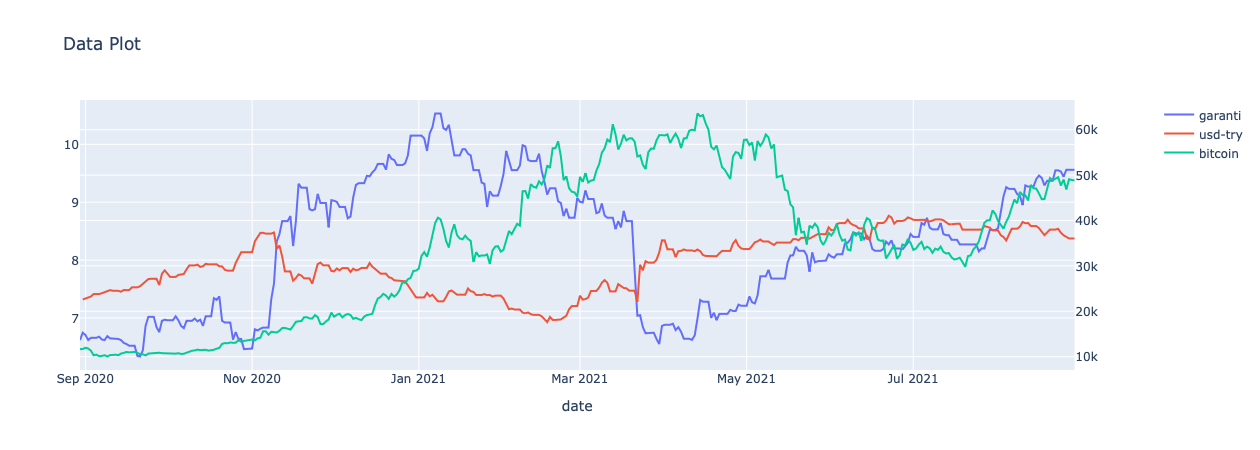

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df.garan, name="garanti"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index, y=df.usdtry, name="usd-try"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index, y=df.bitcoin, name="bitcoin"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Data Plot"
)

# Set x-axis title
fig.update_xaxes(title_text="date")

fig.show()

I will use Efficient Frontier method. Efficient Frontier is basically calculates highest expected return for an optimal risk level or lowest risk level for optimal expected return.
I calculate expected returns as mu and sample covariance as S.

In [7]:
from pypfopt import EfficientFrontier, risk_models,expected_returns
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)

raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
#ef.save_weights_to_file("weights.csv")  # to save file
print(pd.Series(raw_weights))
ef.portfolio_performance(verbose=True)

bitcoin    0.338468
garan      0.183518
usdtry     0.478014
dtype: float64
Expected annual return: 67.4%
Annual volatility: 23.6%
Sharpe Ratio: 2.77


(0.673643056465116, 0.23595829622852962, 2.7701634861443973)

As seen above expected annual return is 69% with 23% volatility.

PyPortfolioOpt also provides a method which allows you to calculate what and how many to buy with budget that you want. 

In [8]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)

da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=1000000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Leftover: ${:.2f}".format(leftover))

Discrete allocation: {'usdtry': 57090, 'bitcoin': 6, 'garan': 19196}
Leftover: $45679.89


If you have multiple portfolio that has relations i will advice to use *Hierarchical Risk Parity* method which use desicion tree like algorithms.

In [11]:
def monte_carlo_simulation(numeric_column, iterations, t_intervals):
    log_returns = np.log(1 + numeric_column.pct_change())
    u = log_returns.mean() #Mean of the logarithmich return
    var = log_returns.var() #Variance of the logarithic return
    drift = u - (0.5 * var) #drift / trend of the logarithmic return
    stdev = log_returns.std() #Standard deviation of the log return
    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))
    S0 = numeric_column.iloc[-1]
    price_list = np.zeros_like(daily_returns)
    price_list[0] = S0
    for t in range(1, t_intervals):
        price_list[t] = price_list[t - 1] * daily_returns[t]
    price_list = pd.DataFrame(price_list)
    price_list['close'] = price_list[0]
    close = numeric_column
    close = pd.DataFrame(close)
    frames = [close, price_list]
    monte_carlo_forecast = pd.concat(frames)
    monte_carlo = monte_carlo_forecast.iloc[:,:].values
    return pd.DataFrame(monte_carlo)
monte_carlo_bitcoin=monte_carlo_simulation(df['bitcoin'], 50, 365)
monte_carlo_usdtry=monte_carlo_simulation(df['usdtry'], 50, 365)
monte_carlo_garan=monte_carlo_simulation(df['garan'], 50, 365)

In [12]:
monte_carlo_bitcoin['avg']=monte_carlo_bitcoin.mean(axis=1)
monte_carlo_usdtry['avg']=monte_carlo_usdtry.mean(axis=1)
monte_carlo_garan['avg']=monte_carlo_garan.mean(axis=1)

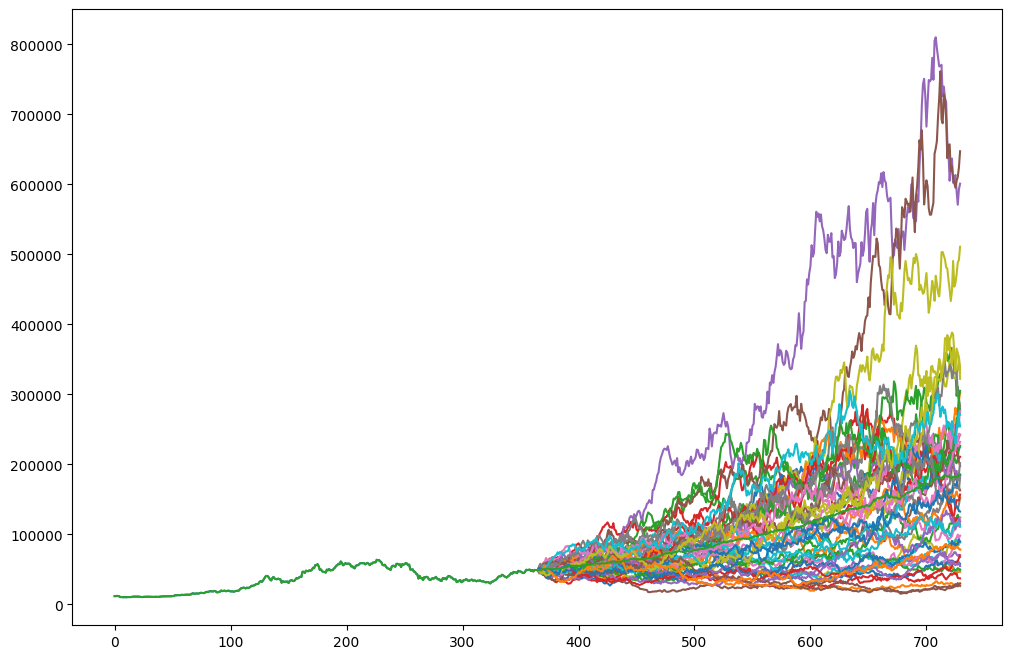

In [13]:
plt.figure(figsize=(12,8))
plt.plot(monte_carlo_bitcoin)
plt.show()

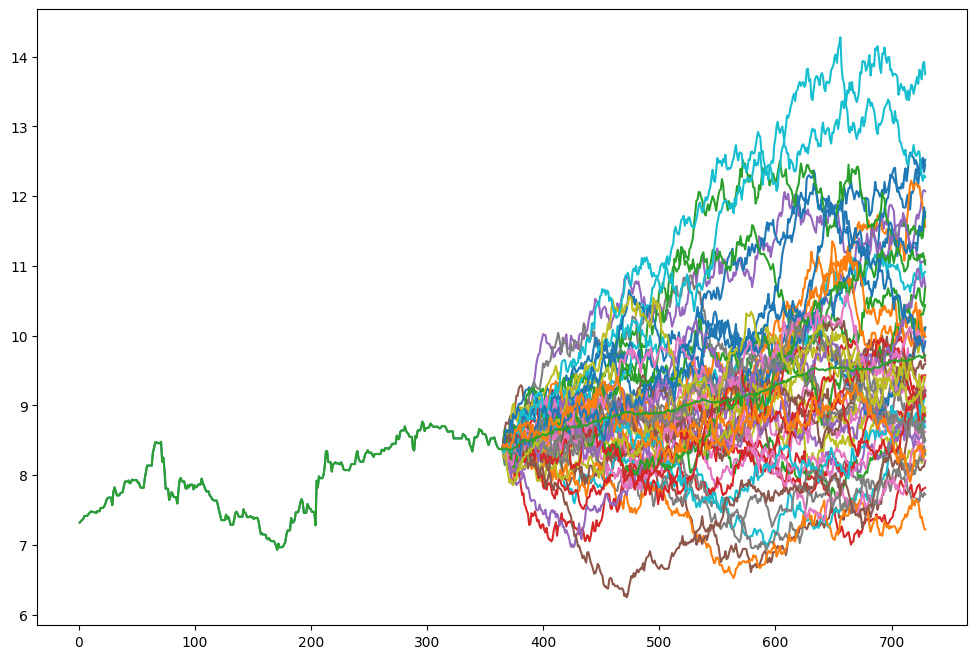

In [14]:
plt.figure(figsize=(12,8))
plt.plot(monte_carlo_usdtry)
plt.show()

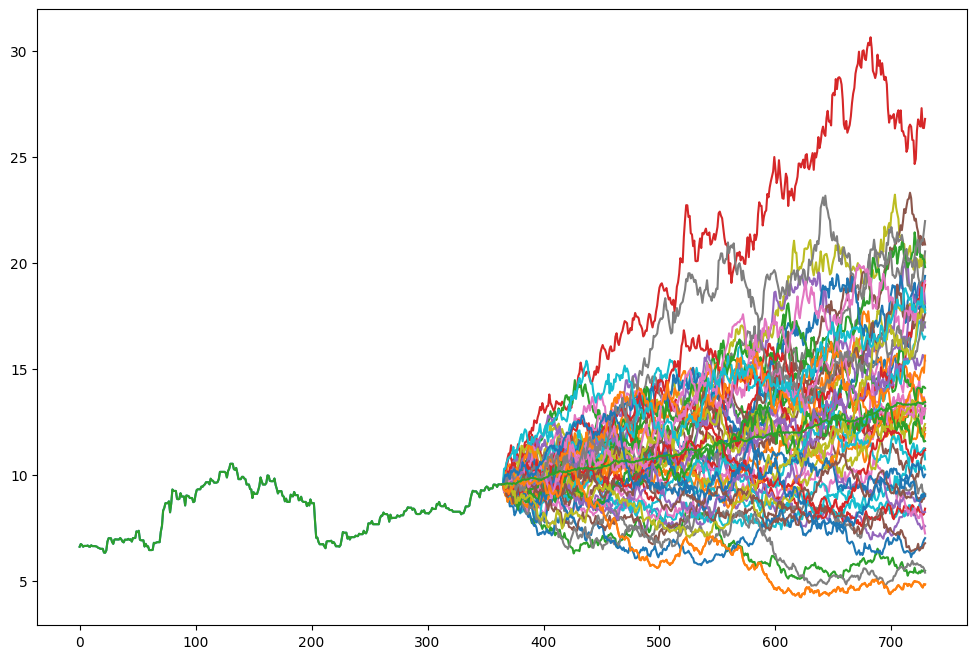

In [15]:
plt.figure(figsize=(12,8))
plt.plot(monte_carlo_garan)
plt.show()

Sources:

https://www.investopedia.com/terms/e/efficientfrontier.asp#:~:text=The%20efficient%20frontier%20is%20the,for%20the%20level%20of%20risk.

https://github.com/robertmartin8/PyPortfolioOpt/tree/1db089602dee348f1eade9b981ca21cd35f1dcca